In [8]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

np.random.seed(42)


"""
Контекст эксперимента:

В продукте запускается новый интерактивный квест.
Планируется добавить:
- прогресс-бар
- небольшие награды за прохождение этапов

Гипотеза:
Добавление прогресс-бара и микро-наград увеличит:
1) долю пользователей, дошедших до конца квеста
2) среднее число правильных ответов

Так как квест запускается впервые и исторических данных нет,
используется симуляция пользовательского поведения
для демонстрации полного цикла A/B теста.
"""


In [12]:
N = 10000  # общее количество пользователей, участвующих в эксперименте

df = pd.DataFrame({
    "user_id": range(N)
})


In [15]:
# Случайным образом делим пользователей на группы:
# control — старая версия квеста
# test — версия с прогресс-баром и наградами
df["group"] = np.random.choice(
    ["control", "test"],
    size=N,          # для каждого пользователя
    p=[0.5, 0.5]     # равное распределение 50/50
)
print(df)

      user_id    group
0           0  control
1           1  control
2           2  control
3           3  control
4           4  control
...       ...      ...
9995     9995     test
9996     9996  control
9997     9997     test
9998     9998     test
9999     9999     test

[10000 rows x 2 columns]


In [16]:
# Не все пользователи, увидевшие квест, начинают его
# Предполагаем, что 70% пользователей нажимают "Начать"
df["started_quest"] = np.random.binomial(
    n=1,        # одна попытка (начал / не начал)
    p=0.7,      # вероятность начала квеста
    size=N
)


In [17]:
# Задаём вероятность завершения квеста
# Control — базовая механика
# Test — улучшенная механика с прогресс-баром
df["finish_prob"] = np.where(
    df["group"] == "control",
    0.25,   # 25% доходят до конца без улучшений
    0.32    # 32% доходят до конца с улучшениями
)


In [18]:
# Пользователь может завершить квест только если он его начал
df["finished_quest"] = np.where(
    df["started_quest"] == 1,                    # проверка условия
    np.random.binomial(1, df["finish_prob"]),    # моделируем завершение
    0                                             # если не начал — не завершил
)


In [19]:
# Если пользователь дошёл до конца квеста,
# моделируем количество правильных ответов
df["correct_answers"] = np.where(
    df["finished_quest"] == 1,
    np.random.poisson(
        lam=np.where(
            df["group"] == "control",
            3.0,    # среднее число правильных ответов в control
            3.6     # чуть выше в test за счёт вовлечённости
        )
    ),
    0
)


In [20]:
# Проверяем, что группы распределены корректно
df["group"].value_counts(normalize=True)


,proportion
group,
control,0.5063
test,0.4937


In [21]:
# Конверсия считается только среди пользователей,
# которые начали квест
conversion = (
    df[df["started_quest"] == 1]
    .groupby("group")["finished_quest"]
    .mean()
)

conversion


,finished_quest
group,
control,0.259681
test,0.321936


In [22]:
avg_correct_answers = (
    df[df["finished_quest"] == 1]
    .groupby("group")["correct_answers"]
    .mean()
)

avg_correct_answers


,correct_answers
group,
control,2.960526
test,3.623762


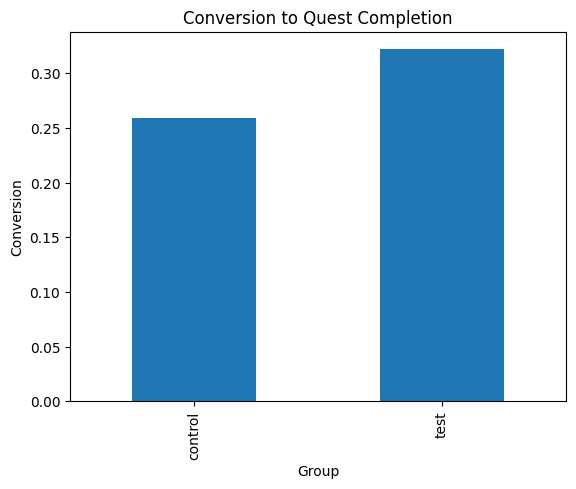

In [23]:
conversion.plot(
    kind="bar",
    title="Conversion to Quest Completion",
    ylabel="Conversion",
    xlabel="Group"
)
plt.show()


In [25]:
from statsmodels.stats.proportion import proportions_ztest

control = df[(df.group == "control") & (df.started_quest == 1)]
test = df[(df.group == "test") & (df.started_quest == 1)]

successes = [
    control.finished_quest.sum(),
    test.finished_quest.sum()
]

observations = [
    len(control),
    len(test)
]

z_stat, p_value = proportions_ztest(successes, observations)

z_stat, p_value


(np.float64(-5.720813693194677), np.float64(1.060150973196053e-08))